### Brand Preference Classification

#### Import libraries

##### - Given some information about customers, predict the brand of computer they prefer (out of 2 possible)
##### - This is a classification problem, not regression

In [1]:
from pycaret.classification import *
import pandas as pd
import os

In [2]:
os.chdir('./Python Projects/Brand Preference')

#### Load in data and understand basic structure

In [3]:
complete_responses = pd.read_csv('CompleteResponses.csv')
incomplete_responses = pd.read_csv('SurveyIncomplete.csv')

In [4]:
print('Shape of complete_responses is: ' + str(complete_responses.shape))
print('Shape of incomplete_responses is: ' + str(incomplete_responses.shape))

Shape of complete_responses is: (9898, 7)
Shape of incomplete_responses is: (5000, 7)


##### - **Both tables are 7 columns wide**

In [5]:
complete_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9898 entries, 0 to 9897
Data columns (total 7 columns):
salary     9898 non-null float64
age        9898 non-null int64
elevel     9898 non-null int64
car        9898 non-null int64
zipcode    9898 non-null int64
credit     9898 non-null float64
brand      9898 non-null int64
dtypes: float64(2), int64(5)
memory usage: 541.4 KB


In [6]:
incomplete_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
salary     5000 non-null float64
age        5000 non-null int64
elevel     5000 non-null int64
car        5000 non-null int64
zipcode    5000 non-null int64
credit     5000 non-null float64
brand      5000 non-null int64
dtypes: float64(2), int64(5)
memory usage: 273.6 KB


##### **There are a couple columns that need to change data types. Columns such as 'elevel', 'car', and 'zipcode' should be categorical, not numeric. Column 'brand' is the target. This can be addressed during model setup.

#### Begin setup

In [7]:
clfl = setup(complete_responses, target = 'brand', session_id = 123)

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(9898, 7)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


##### - After running the setup, data types were actually inferred correctly, so no need to convert.

In [8]:
best_models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.9202,0.9804,0.9317,0.9397,0.9356,0.8307,0.831,3.948
1,Light Gradient Boosting Machine,0.9184,0.9786,0.9303,0.9382,0.9342,0.827,0.8273,0.1066
2,Extreme Gradient Boosting,0.9154,0.9767,0.9315,0.9325,0.9319,0.8202,0.8204,0.3452
3,Gradient Boosting Classifier,0.9104,0.9658,0.9023,0.9512,0.9258,0.8128,0.8152,0.994
4,Decision Tree Classifier,0.8951,0.8886,0.9153,0.916,0.9155,0.777,0.7772,0.029
5,Random Forest Classifier,0.8489,0.9143,0.8537,0.8983,0.8753,0.6838,0.6854,0.042
6,Extra Trees Classifier,0.8037,0.8901,0.8795,0.8188,0.8479,0.5722,0.5756,0.292
7,Ada Boost Classifier,0.7219,0.7752,0.7514,0.7909,0.7703,0.4182,0.4196,0.3551
8,Naive Bayes,0.7006,0.7664,0.8649,0.7141,0.7822,0.3172,0.3328,0.0085
9,K Neighbors Classifier,0.6829,0.7272,0.7583,0.7387,0.7483,0.32,0.3204,0.0646


##### - Appears CatBoost Classifier and Light GBM are the best choices. I'm going to use Light GBM as it performs nearly as well, is much faster to run, and is much easier to use with other features of Pycaret.

In [9]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9177,0.9778,0.9234,0.9431,0.9332,0.8263,0.8266
1,0.9307,0.9786,0.9374,0.9506,0.9439,0.8534,0.8535
2,0.9264,0.9801,0.9188,0.9612,0.9395,0.8457,0.8471
3,0.9163,0.9779,0.935,0.9307,0.9329,0.8218,0.8218
4,0.9177,0.9775,0.9374,0.9309,0.9341,0.8247,0.8247
5,0.925,0.9834,0.9327,0.9459,0.9393,0.8412,0.8413
6,0.9163,0.9797,0.9397,0.9268,0.9332,0.8212,0.8214
7,0.8961,0.9722,0.9233,0.9106,0.9169,0.7784,0.7785
8,0.9104,0.9783,0.9233,0.9319,0.9276,0.8102,0.8102
9,0.9277,0.981,0.9326,0.9502,0.9413,0.8474,0.8476


In [10]:
predict_model(lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9215,0.9806,0.9253,0.9473,0.9362,0.8344,0.8348


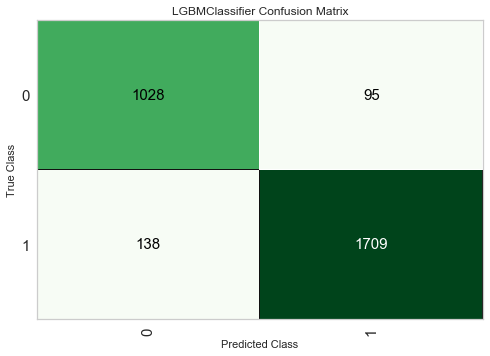

In [11]:
plot_model(lightgbm, plot = 'confusion_matrix')

In [12]:
final_model = finalize_model(lightgbm)

In [13]:
predict_model(final_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.962,0.9954,0.9626,0.9759,0.9692,0.9194,0.9196


In [14]:
predictions = predict_model(final_model, data = incomplete_responses)

In [15]:
predictions_compare = predictions[:103]

##### - After examining the incomplete responses, it appears to be a file of 5,000 reponses where the first 102 were filled out. The remaining 4,898 need to be predicted. Therefore, we can test the predictions on a subset of this set of "incomplete responses".

In [16]:
predictions_compare['Correct?'] = (predictions_compare['brand'].astype('str') == predictions_compare['Label'].astype('str')).astype('object')

##### - Add a column to test whether the prediction was accurate

In [17]:
predictions_compare.head()

,salary,age,elevel,car,zipcode,credit,brand,Label,Score,Correct?
0,150000.00000,76,1,3,3,377980.1016,1,1,0.9999,True
1,82523.83897,51,1,8,3,141657.6066,0,0,0.0635,True
2,115646.63620,34,0,10,2,360980.3585,1,1,0.9924,True
3,141443.39330,22,3,18,2,282736.3191,1,1,0.9999,True
4,149211.27030,56,0,5,3,215667.2896,1,1,0.9999,True


In [18]:
predictions_compare[predictions_compare['Correct?'] == False].head()

,salary,age,elevel,car,zipcode,credit,brand,Label,Score,Correct?
22,47920.93459,40,4,17,2,258034.2439,0,1,0.8230,False
23,125879.92630,50,0,10,2,123780.8945,0,1,0.5207,False
26,28483.92748,70,3,14,4,340911.0087,1,0,0.2180,False
36,21345.30153,58,2,17,1,229348.2591,0,1,0.9599,False
52,69616.73695,58,2,9,5,419945.1777,0,1,0.6348,False


##### Check a couple to make sure it worked out correctly

In [19]:
len(predictions_compare[predictions_compare['Correct?'] == True]) / len(predictions_compare)

0.8737864077669902

##### Looks like the model accurately predicted the preferred brand 87.4% of the time in the holdout surveys (subset from incomplete_responses). This is slightly lower than the accuracy score when setting up the model. 